In [3]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [4]:
data_path = r'WindData\NWP\data.xlsx'
df = pd.read_excel(data_path)
df.columns=['日期','时间','层高(m)','风速(m/s)','风向(°)','湿度(RH)','温度(℃)','气压(KPa)','空气密度(kg/m³)','层高','风向','风速','实际功率(MW)']
df.head(5)

,日期,时间,层高(m),风速(m/s),风向(°),湿度(RH),温度(℃),气压(KPa),空气密度(kg/m³),层高,风向,风速,实际功率(MW)
0,2019-10-01,00:00:00,90,10.7,211,80.4,14,87.18,1.059,90,261.57,11.25,31.768133
1,2019-10-01,00:15:00,90,10.7,211,81.4,14,87.18,1.059,90,262.28,9.89,32.380400
2,2019-10-01,00:30:00,90,10.6,211,82.4,14,87.18,1.059,90,264.46,10.66,34.551067
3,2019-10-01,00:45:00,90,10.5,211,83.4,13,87.18,1.062,90,264.60,10.82,34.539200
4,2019-10-01,01:00:00,90,10.4,211,84.4,13,87.18,1.062,90,262.53,11.12,34.655067


In [5]:
df.columns=['date','time','height pre','wind speed pre','wind direction pre','humidity pre','temp pre','atmospheric pressure pre','air density pre','height','wind direction','wind speed','power']
df.head()

,date,time,height pre,wind speed pre,wind direction pre,humidity pre,temp pre,atmospheric pressure pre,air density pre,height,wind direction,wind speed,power
0,2019-10-01,00:00:00,90,10.7,211,80.4,14,87.18,1.059,90,261.57,11.25,31.768133
1,2019-10-01,00:15:00,90,10.7,211,81.4,14,87.18,1.059,90,262.28,9.89,32.380400
2,2019-10-01,00:30:00,90,10.6,211,82.4,14,87.18,1.059,90,264.46,10.66,34.551067
3,2019-10-01,00:45:00,90,10.5,211,83.4,13,87.18,1.062,90,264.60,10.82,34.539200
4,2019-10-01,01:00:00,90,10.4,211,84.4,13,87.18,1.062,90,262.53,11.12,34.655067


In [13]:
df_processed = df# 合并date和time
df_processed['date_time'] = df_processed['date'].astype(str) + ' ' + df_processed['time'].astype(str)
df_processed['date_time'] = pd.to_datetime(df_processed['date_time'])
df_processed = df_processed.drop(['date','time'], axis=1)
df_processed.head()

,height pre,wind speed pre,wind direction pre,humidity pre,temp pre,atmospheric pressure pre,air density pre,height,wind direction,wind speed,power,date_time
0,90,10.7,211,80.4,14,87.18,1.059,90,261.57,11.25,31.768133,2019-10-01 00:00:00
1,90,10.7,211,81.4,14,87.18,1.059,90,262.28,9.89,32.380400,2019-10-01 00:15:00
2,90,10.6,211,82.4,14,87.18,1.059,90,264.46,10.66,34.551067,2019-10-01 00:30:00
3,90,10.5,211,83.4,13,87.18,1.062,90,264.60,10.82,34.539200,2019-10-01 00:45:00
4,90,10.4,211,84.4,13,87.18,1.062,90,262.53,11.12,34.655067,2019-10-01 01:00:00


In [27]:
valid_features = ['wind speed pre','wind speed','power','date_time']
df_processed = df_processed[valid_features]
df_processed.head()

,wind speed pre,wind speed,power,date_time
0,10.7,11.25,31.768133,2019-10-01 00:00:00
1,10.7,9.89,32.380400,2019-10-01 00:15:00
2,10.6,10.66,34.551067,2019-10-01 00:30:00
3,10.5,10.82,34.539200,2019-10-01 00:45:00
4,10.4,11.12,34.655067,2019-10-01 01:00:00


In [29]:
df_processed['item_id']=0

In [30]:
data_ag = TimeSeriesDataFrame.from_data_frame(df_processed, timestamp_column='date_time', id_column='item_id')

In [31]:
data_ag.head()

wind speed pre  wind speed      power
item_id timestamp                                                 
0       2019-10-01 00:00:00            10.7       11.25  31.768133
        2019-10-01 00:15:00            10.7        9.89  32.380400
        2019-10-01 00:30:00            10.6       10.66  34.551067
        2019-10-01 00:45:00            10.5       10.82  34.539200
        2019-10-01 01:00:00            10.4       11.12  34.655067

In [32]:
df_regular = data_ag.convert_frequency(freq="15T")
df_regular.isna().sum()

wind speed pre    2611
wind speed        2611
power             2611
dtype: int64

In [33]:
df_regular = df_regular.fill_missing_values(method='ffill')
df_regular.isna().sum()

wind speed pre    0
wind speed        0
power             0
dtype: int64

In [34]:
data_corr = pd.DataFrame(df_regular.loc[(0,)]).corr()
data_corr

,wind speed pre,wind speed,power
wind speed pre,1.000000,0.706291,0.769285
wind speed,0.706291,1.000000,0.744020
power,0.769285,0.744020,1.000000


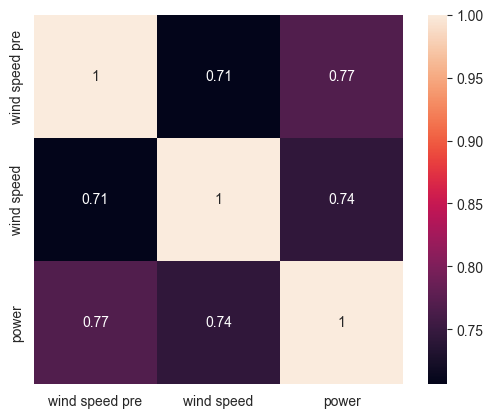

In [35]:
sns.heatmap(data_corr,annot=True, square=True)
plt.show()

In [36]:
df_regular.describe()

,wind speed pre,wind speed,power
count,37988.000000,37988.000000,37988.000000
mean,7.198758,8.224735,19.500588
std,3.160603,3.790091,15.439395
min,0.000000,0.000000,0.000000
25%,4.800000,5.350000,5.416933
50%,7.000000,7.900000,15.926167
75%,9.400000,10.940000,33.403650
max,20.400000,20.970000,50.230467


In [37]:
df_regular.head()

wind speed pre  wind speed      power
item_id timestamp                                                 
0       2019-10-01 00:00:00            10.7       11.25  31.768133
        2019-10-01 00:15:00            10.7        9.89  32.380400
        2019-10-01 00:30:00            10.6       10.66  34.551067
        2019-10-01 00:45:00            10.5       10.82  34.539200
        2019-10-01 01:00:00            10.4       11.12  34.655067

In [38]:
df_regular.tail()

wind speed pre  wind speed      power
item_id timestamp                                                 
0       2020-10-30 15:45:00             6.8        6.90  11.326533
        2020-10-30 16:00:00             7.1        6.62   8.809000
        2020-10-30 16:15:00             7.4        8.02  12.102800
        2020-10-30 16:30:00             7.8        8.75  15.669333
        2020-10-30 16:45:00             8.1        8.12  16.286267

In [49]:
target_name = ['power']
past_covariates_name = ['wind speed']
known_covariates_name = df_regular.columns.difference(target_name + past_covariates_name)
known_covariates_name

Index(['wind speed pre'], dtype='object')

In [50]:
prediction_length = 4*24
train_data, test_data = df_regular.train_test_split(prediction_length*3)

In [51]:
# 加入sklearn 归一化预处理,注意要保留pandas的数据结构
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_index = train_data.index
train_columns = train_data.columns
test_index = test_data.index
test_columns = test_data.columns
train_data = pd.DataFrame(scaler.fit_transform(train_data),index=train_index,columns=train_columns)
test_data = pd.DataFrame(scaler.transform(test_data),index=test_index,columns=test_columns)
train_data = TimeSeriesDataFrame.from_data_frame(train_data)
test_data = TimeSeriesDataFrame.from_data_frame(test_data)

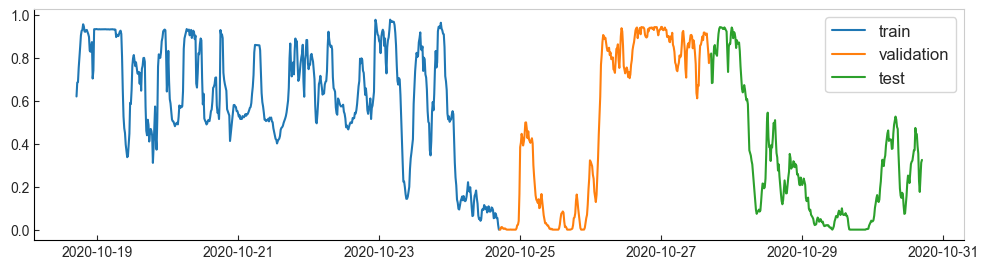

In [468]:
# 作图训练集、验证集和测试集
fig,ax = plt.subplots(figsize=(12, 3))
item_id=0
ax.plot(train_data.loc[item_id]['power'][-9*prediction_length:-3*prediction_length],label='train')
ax.plot(train_data.loc[item_id]['power'][-3*prediction_length:],label='validation')
ax.plot(test_data.loc[item_id]['power'][-3*prediction_length:],label='test')

# ax.grid(True, which='major', axis='x', linestyle='--', color='grey', alpha=0.5)  # Add gridlines
ax.grid(False)
ax.xaxis.set_tick_params(which='both', bottom=True, top=False, direction='in')
ax.yaxis.set_tick_params(which='both', left=True, right=False, direction='in')

# Set axis colors
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

ax.legend(fontsize=12)
plt.savefig('WF_train_val_test.svg')
plt.show()

In [53]:
# 得到根据置信概率得到分位数水平,结果保留三位小数
prob_list = [95,90,85,50,25,10]
quantile_levels = [(1 - p/100)/2  for p in prob_list]+[0.5]+[0.5+(p/100)/2  for p in prob_list]
quantile_levels = [round(i,3) for i in quantile_levels]
quantile_levels.sort()
quantile_levels

[0.025,
 0.05,
 0.075,
 0.25,
 0.375,
 0.45,
 0.5,
 0.55,
 0.625,
 0.75,
 0.925,
 0.95,
 0.975]

In [ ]:

predictor = TimeSeriesPredictor(
    # 生成95,90,85,75,50,25,10的分位数
    quantile_levels=quantile_levels,
    prediction_length=prediction_length,
    eval_metric="RMSE",
    freq="15T",
    known_covariates_names=known_covariates_name,
    target="power",
)
predictor.fit(
    train_data,
    presets="best_quality",
    num_val_windows=3,
    # time_limit=60*60*2.5,
    refit_every_n_windows=1,
    refit_full=True
)

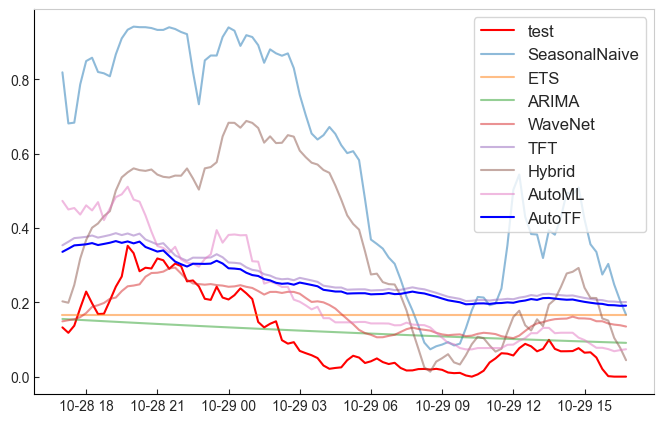

In [472]:
# 作图训练集、验证集和测试集
item_id=0
fig,ax = plt.subplots(figsize=(8, 5))
item_id=0
ax.plot(test_data.loc[item_id]['power'][-2*prediction_length:-1*prediction_length],label='test',color='r')
# import hybrid_model
# import autoTF

# ax.grid(True, which='major', axis='x', linestyle='--', color='grey', alpha=0.5)  # Add gridlines
ax.grid(False)
# Set tick parameters
ax.xaxis.set_tick_params(which='both', bottom=True, top=False, direction='in')
ax.yaxis.set_tick_params(which='both', left=True, right=False, direction='in')
# Set axis colors
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

ax.legend(fontsize=12)
# plt.savefig('pre_first_24h.svg')
plt.show()


# 模式匹配

In [346]:
# 计算余弦相似度(趋势相似度)，越大越好
def sim_cos(x,y):
    v = np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y)+0.00001)
    # print(v)
    return v
# 计算相关系数
def sim_corr(x,y):
    v = np.corrcoef(x,y)[0,1]
    # print(v)
    return v
# 计算幅值相似度，越大越好
def sim_val(x,y):
    v = 1-np.abs(np.linalg.norm(x)-np.linalg.norm(y))
    return v
# 综合相似度
def sim(x,y):
    return (sim_corr(x,y)+sim_val(x,y))/2
    # return 1-np.linalg.norm(x-y)

In [ ]:
# 假设我们要预测测试集的第一个样本，那么训练数据为train_data，此时我们将train data的2个prediction的历史数据与过去的历史数据匹配，计算相关性或余弦相似度，然后选择最相似的数据，然后计算各个模型在这个数据上的预测值，然后根据预测结果计算权重分配，然后根据权重计算最终的预测值
i=0
pattern_size = prediction_length
# def match_weight(pattern_size,i):
    
sample_power = test_data[-pattern_size*(4-i):-pattern_size*(3-i)]['power']
sample_wind_speed = test_data[-pattern_size*(4-i):-pattern_size*(3-i)]['wind speed']
sample_wind_speed_pre = test_data[-pattern_size-(2-i)*prediction_length:None if i==2 else -(2-i)*prediction_length]['wind speed pre']

search_power = test_data[:-pattern_size*(4-i)]['power']
search_wind_speed = test_data[:-pattern_size*(4-i)]['wind speed']
search_wind_speed_pre = test_data[:None if i==2 else -(2-i)*prediction_length]['wind speed pre']
# search_wind_speed_pre的索引的第二层的时间要向过去移动pattern_size*15min的长度
search_wind_speed_pre.index = search_wind_speed_pre.index.set_levels(search_wind_speed_pre.index.levels[1]-pd.Timedelta(minutes=pattern_size*15),level=1)
sim_power = search_power.rolling(min_periods=pattern_size,window=pattern_size).apply(lambda x:sim(x.values,sample_power.values))
sim_wind_speed = search_wind_speed.rolling(min_periods=pattern_size,window=pattern_size).apply(lambda x:sim(x.values,sample_wind_speed.values))
sim_wind_speed_pre = search_wind_speed_pre.rolling(min_periods=pattern_size,window=pattern_size).apply(lambda x:sim(x.values,sample_wind_speed_pre.values))
sim_final = (sim_wind_speed_pre + sim_power + sim_wind_speed)/3
max_sim_index=sim_final.idxmax()
match_power_data = test_data.loc[0]['power'][max_sim_index[1]-pd.Timedelta(minutes=15*95):max_sim_index[1]]

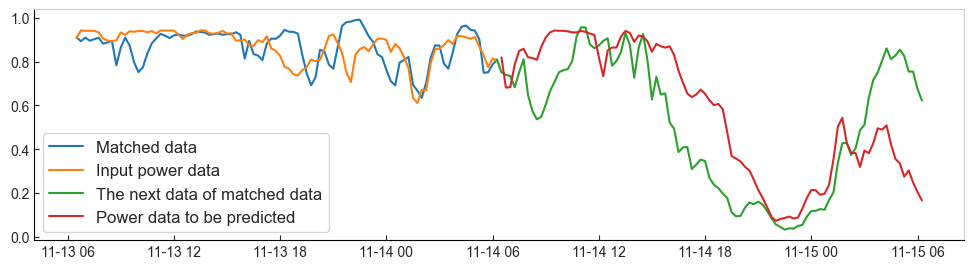

In [488]:

# 现在知道了相似度最大的时间窗
predictions = predictor.predict(test_data[:sim_final.idxmax()],known_covariates=test_data,model='DirectTabular_FULL')
# 作图训练集、验证集和测试集
fig,ax = plt.subplots(figsize=(12, 3))
item_id=0
ax.plot(match_power_data,label='Matched data')
ax.plot(match_power_data.index,sample_power.values,label='Input power data')
# plt.plot(predictions.loc[item_id]['mean'],label='pre')
ax.plot(test_data.loc[0]['power'][max_sim_index[1]:max_sim_index[1]+pd.Timedelta(minutes=15*96)],label='The next data of matched data')
ax.plot(predictions.index.get_level_values(1),test_data.loc[0]['power'][-pattern_size-(2-i)*prediction_length:None if i==2 else -(2-i)*prediction_length].values,label='Power data to be predicted')
# ax.grid(True, which='major', axis='x', linestyle='--', color='grey', alpha=0.5)  # Add gridlines
ax.grid(False)
ax.xaxis.set_tick_params(which='both', bottom=True, top=False, direction='in')
ax.yaxis.set_tick_params(which='both', left=True, right=False, direction='in')

# Set axis colors
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

ax.legend(fontsize=12)
# plt.tight_layout()
plt.savefig('WF_match_sample.pdf')
plt.show()
plt.show()
    

In [ ]:
# 根据前向选择计算权重
def weight_cal1():
    model_pre_list = []
    for model_n in model_list:
        model_pre = predictor.predict(test_data[:sim_final.idxmax()],known_covariates=test_data,model=model_n+"_FULL")
        model_pre_list.append(model_pre)
    # 真实值
    y_true = test_data.loc[0]['power'][max_sim_index[1]+pd.Timedelta(minutes=15*1):max_sim_index[1]+pd.Timedelta(minutes=15*96)].values
    # 预测值
    X = np.array([model_pre['mean'].values for model_pre in model_pre_list])
    # 计算权重，值得注意的是，权重要大于等于0，且加起来等于1
    import cvxpy as cp
    from sklearn.metrics import mean_squared_error
    # Assuming y_preds is a list of model predictions and y_true is the array of true values
    # Initialize the ensemble
    best_ensemble = []
    best_ensemble_score = float('inf')
    ensemble_candidates = list(range(len(model_pre_list)))
    
    # Convex optimization setup
    def solve_weights(y_preds_ensemble, y_true):
        weights = cp.Variable(len(y_preds_ensemble))
        objective = cp.Minimize(cp.sum_squares(cp.matmul(weights, np.array(y_preds_ensemble)) - y_true)+ 0.1 * cp.norm(weights, 2))
        constraints = [cp.sum(weights) == 1, weights >= 0]
        prob = cp.Problem(objective, constraints)
        prob.solve()
        return weights.value
    # Forward selection with convex optimization
    for _ in range(100):  # Maximum of 100 iterations
        best_candidate = None
        best_candidate_weights = None
    
        for i in ensemble_candidates:
            # Create a temporary ensemble with the candidate
            temp_ensemble = best_ensemble + [i]
            temp_y_preds_ensemble = [X[j] for j in temp_ensemble]
            # print(temp_y_preds_ensemble.shape,y_true.shape)
            # Solve for the best weights of the current ensemble
            temp_weights = solve_weights(temp_y_preds_ensemble, y_true)
            temp_ensemble_prediction = np.dot(temp_weights, np.array(temp_y_preds_ensemble))
            
            # Evaluate the candidate ensemble
            candidate_score = mean_squared_error(y_true, temp_ensemble_prediction)
            
            if candidate_score < best_ensemble_score:
                best_candidate = i
                best_ensemble_score = candidate_score
                best_candidate_weights = temp_weights
    
        # If a better candidate was found, update the ensemble
        if best_candidate is not None:
            best_ensemble.append(best_candidate)
            ensemble_candidates.remove(best_candidate)
            ensemble_weights = best_candidate_weights
        else:
            break

    # Final ensemble prediction
    y_pred = np.dot(ensemble_weights, np.array([X[i] for i in best_ensemble]))
    # 预测值
    # y_pred = np.dot(w,X)
    # 作图
    plt.plot(y_true,label='True')
    plt.plot(y_pred,label='Predict')
    plt.legend()
    plt.show()
    return ensemble_weights,best_ensemble
ensemble_weights,best_ensemble = weight_cal1()

In [424]:
test_pre_list = []
for model_n in model_list:
    model_pre = predictor.predict(test_data[:-pattern_size*(3-i)],known_covariates=test_data,model=model_n+"_FULL")
    test_pre_list.append(model_pre)

In [ ]:
X = np.array([model_pre['mean'].values for model_pre in test_pre_list])
y_true = test_data.loc[0]['power'][-pattern_size*(3-i):None if 2-i==0 else -pattern_size*(2-i)].values
y_pred = np.dot(ensemble_weights, np.array([X[i] for i in best_ensemble]))
# 作图
plt.plot(y_true,label='True')
plt.plot(y_pred,label='Predict')
plt.legend()